In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/bm_proj

/content/drive/MyDrive/bm_proj


In [ ]:
#!pip install split-folders[full]

# Environment

In [3]:
import torch
from torch.functional import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support)

import numpy as np
import seaborn as sn
import cv2
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from collections import OrderedDict

import tqdm
from tqdm.auto import tqdm

#import splitfolders


In [4]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data

In [5]:
%cd /content/drive/MyDrive/bm_proj/images

/content/drive/MyDrive/bm_proj/images


In [ ]:
#splitfolders.ratio('.', output="output", seed=1337, ratio=(.5, 0.2, 0.3))

Ratio is approx 3:1:2 in coherence with the original paper.

In [6]:
IMG_MEAN = [123.675, 116.28, 103.53]
IMG_STD = [58.395, 57.12, 57.375]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])

img_norm values from original code.

In [7]:
print(len(os.listdir('output/train/health')))
print(len(os.listdir('output/val/health')))
print(len(os.listdir('output/test/health')))

1900
760
1140


In [8]:
BATCH_SIZES = [8, 16, 32, 64, 128]


train_dataset = torchvision.datasets.ImageFolder(root='output/train', transform=train_transform)
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True
                          )

val_dataset = torchvision.datasets.ImageFolder(root='output/val', transform=test_transform)
val_loader = DataLoader(val_dataset,
                        batch_size=32,
                        shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(root='output/test', transform=test_transform)
test_loader = DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=True)

#Model

In [9]:
classes = 'health', 'sick', 'tb'
n_classes = len(classes)

model = models.resnet50(weights='IMAGENET1K_V1').to(dev)

from torchsummary import summary
summary(model, (3, 512, 512))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [10]:
weights = torch.load('/content/drive/MyDrive/bm_proj/saved_model2.pth', map_location=torch.device(dev))
print(weights.keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [ ]:
model.fc = nn.Linear(2048, n_classes, bias=True)

for name, param in model.named_parameters():
    if 'layer4.2.bn3' in name or 'fc' in name:
        param = weights[name]
        param.requires_grad = True
    else:
        #print(name)
        param.requires_grad = False #freeze

summary(model.to(dev), (3, 512, 512))


# Optimizer and other variables

In [12]:
lr=0.0005

# AdamW
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss()


# Training and Validation

In [13]:
model = model.to(dev)

In [15]:
def train(model, trainloader, optimizer, criterion):
    counter = 0
    cum_loss = 0.00
    cum_correct = 0
    cum_samples = 0

    model.train()

    for inputs, targets in tqdm(trainloader):
        if counter == 1: break

        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(dev), targets.to(dev)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets.squeeze())
        cum_loss += loss

        _, predicted = torch.max(outputs, 1)
        cum_correct += (predicted == targets).sum().item()
        cum_samples += targets.size(0)

        loss.backward()
        optimizer.step()

        counter += 1

    epoch_loss = cum_loss / counter
    epoch_accu = cum_correct / cum_samples
    return epoch_loss, epoch_accu

In [16]:
def val(model, valloader, criterion):
    counter = 0
    cum_loss = 0.00
    cum_correct = 0
    cum_samples = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(valloader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(dev), targets.to(dev)

            outputs = model(inputs)

            loss = criterion(outputs.squeeze(), targets.squeeze())
            cum_loss += loss

            _, predicted = torch.max(outputs, 1)
            cum_correct += (predicted == targets).sum().item()
            cum_samples += targets.size(0)

            counter += 1

    epoch_loss = cum_loss / counter
    epoch_accu = cum_correct / cum_samples
    return epoch_loss, epoch_accu

In [ ]:
NUM_EPOCHS = 10
train_losses = []
train_accus = []
val_losses = []
val_accus = []

for epoch in range(NUM_EPOCHS):
    print(f"\nTraining epoch {epoch + 1}/{NUM_EPOCHS}: ")
    epoch_loss, epoch_accu = train(model, train_loader, optimizer, criterion)
    train_losses.append(float(epoch_loss))
    train_accus.append(float(epoch_accu))
    print(f"Training loss: {epoch_loss:.6f}")
    print(f"Training accuracy: {epoch_accu:.6f} \n")

    print(' Validating...')
    epoch_loss, epoch_accu = val(model, val_loader, criterion)
    val_losses.append(float(epoch_loss))
    val_accus.append(float(epoch_accu))
    print(f"Validation loss: {epoch_loss:.6f}")
    print(f"Validation accuracy: {epoch_accu:.6f} \n")


Training epoch 1/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.462779
Training accuracy: 0.840476 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.424373
Validation accuracy: 0.873810 


Training epoch 2/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.415687
Training accuracy: 0.859286 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.371268
Validation accuracy: 0.894643 


Training epoch 3/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.404360
Training accuracy: 0.865476 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.344715
Validation accuracy: 0.897024 


Training epoch 4/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.375972
Training accuracy: 0.878095 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.344065
Validation accuracy: 0.895833 


Training epoch 5/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.369880
Training accuracy: 0.873571 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.325096
Validation accuracy: 0.886905 


Training epoch 6/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.337017
Training accuracy: 0.888333 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.294024
Validation accuracy: 0.907738 


Training epoch 7/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.326852
Training accuracy: 0.891429 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.287041
Validation accuracy: 0.915476 


Training epoch 8/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.325268
Training accuracy: 0.880952 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.275197
Validation accuracy: 0.914286 


Training epoch 9/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.309119
Training accuracy: 0.899524 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.264328
Validation accuracy: 0.915476 


Training epoch 10/10: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.298603
Training accuracy: 0.899048 

 Validating...


  0%|          | 0/42 [00:00<?, ?it/s]

Validation loss: 0.258676
Validation accuracy: 0.916071 



In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/bm_proj/saved_model3.pth')

In [ ]:
%cd /content/drive/MyDrive/bm_proj/plots

/content/drive/MyDrive/bm_proj/plots


In [ ]:
import csv

with open('loss_and_accu.csv', 'a') as f:

    write = csv.writer(f)

    #fields = ['train_losses', 'val_losses', 'train_accus', 'val_accus']

    lists = [train_losses, val_losses, train_accus, val_accus]

    #write.writerow(fields)
    write.writerows(lists)

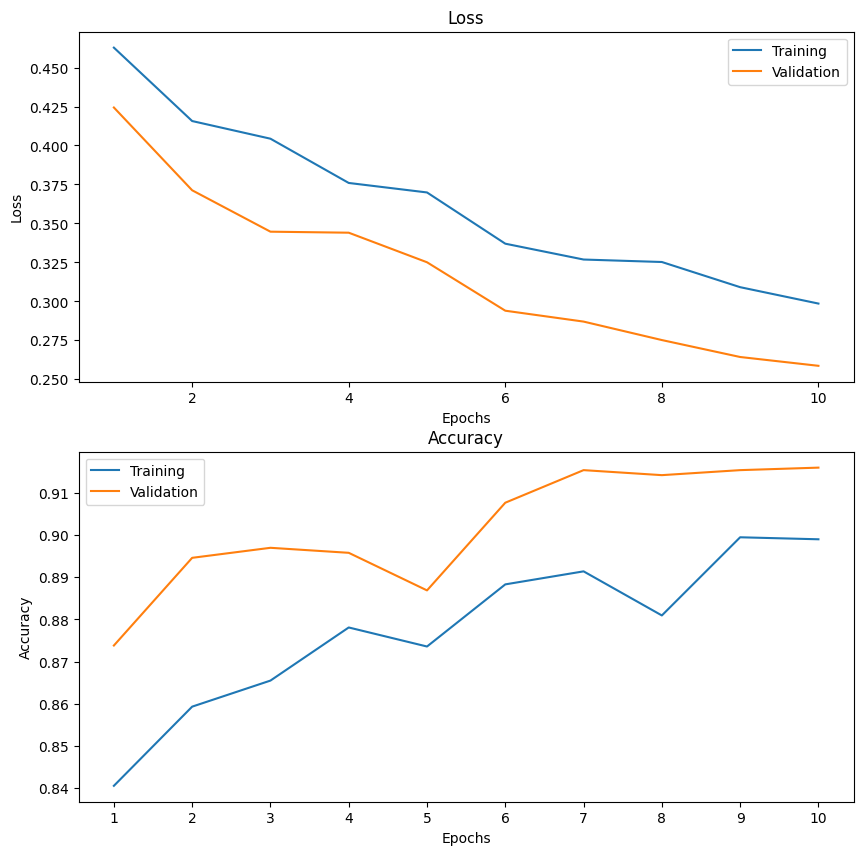

In [ ]:
x = range(1, NUM_EPOCHS+1)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1))

axes[0].plot(x, train_losses, label="Training")
axes[0].plot(x, val_losses, label="Validation")
axes[0].title.set_text('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(x, train_accus, label="Training")
axes[1].plot(x, val_accus, label="Validation")
axes[1].title.set_text('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig('2ndrun_7epoches.png')

plt.show()


# Testing

In [ ]:
def test(model, testloader):
    cum_correct = 0
    cum_samples = 0
    i = 0

    y_pred = []
    y_true = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            if i == 5:
              break

            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(dev), targets.to(dev)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            cum_correct += (predicted == targets).sum().item()
            cum_samples += targets.size(0)

            y_pred.extend(predicted.tolist()) # Save Prediction
            y_true.extend(targets.tolist()) # Save Truth

            i+=1

    accu = cum_correct / cum_samples
    return accu, y_pred, y_true

In [ ]:
print(' Testing...')
accu, y_pred, y_true = test(model, test_loader)
print(accu)


In [ ]:
print(f"Test accuracy: {accu:.6f} \n")

In [ ]:
print(y_true)
print(y_pred)

In [ ]:
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_pred, y_true)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# git

In [17]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [19]:
!git push https://github.com/rhf220/Chest-X-ray-TB

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
